## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [3]:
import pickle
import random
from datetime import datetime
import numpy as np
import torch
import datasets
from datasets import Dataset, load_metric
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler)
from transformers import AutoModelForMultipleChoice, BertTokenizerFast


In [4]:
counter = 0
SESS_NAME = datetime.now().strftime("%y%m%d%H%M")
datadir = "../data"
modeldir = "../data/models"
###########################
datafile = f"{datadir}/refined_dot_type_5.0.csv"
dataset_dir = f"{datadir}/PT2_encoded_dataset"

In [5]:
encoded_dataset = datasets.load_from_disk(dataset_dir)
len(encoded_dataset["train"])

455

In [6]:
encoded_dataset["train"].select([0,2]).to_pandas()

,type_class,eng word,word,pos,instance,src,dot_type_2,dot_type_1,label,zh_type_class,zh_dot_type,zh_dot_type_2,zh_dot_gloss,is_2choice,is_one_ans,class_selector,__index_level_0__,input_ids,token_type_ids,attention_mask
0,"event,human",appointment,個案,Na,這棟預售<個案>基地面積五百零八坪屬商三土地。,ASBC,event,event,0,"事件,人類",事件,事件,事情、事項。,True,True,"[[6], [8]]",251,"[[101, 6857, 3477, 7521, 1545, 133, 943, 3428,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,"act,proposition",allegation,宣稱,nom,在不能提供證據的前提下，我對他的<宣稱>感到懷疑。,CWN2,proposition,proposition,1,"行為,命題",命題,命題,邏輯學上指表達判斷的語句。通常以直陳語句或假定句表達。,True,True,"[[2], [9]]",33,"[[101, 1762, 679, 5543, 2990, 897, 6349, 3087,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."


## Data preparation

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

In [8]:
from dataclasses import dataclass
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """
    tokenizer = tokenizer
    padding, trunc = True, True
    max_length =  None
    pad_to_multiple_of = None
    def __init__(self, device=torch.device("cpu")):
        self.device = device
        
    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        pin_label = True if "label" in features[0].keys() else False
        # print("pinned label?", pin_label) # whether label column is correctly pinpointed 
        labels = [feature.pop(label_name) for feature in features]
        seq_classes = [feature.pop('class_selector') for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        accepted_keys = ["input_ids", "attention_mask", "label", "token_type_ids", 'class_selector']
        flattened_features = [[{k: v[i] for k, v in feature.items() if k in accepted_keys} 
                               for i in range(num_choices)] for feature in features]        
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding= "longest",
            max_length= self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
    
        # filtering
        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items() if k in accepted_keys}        
    
        # prompt selectors
        batch["class_selector"] = torch.tensor(seq_classes)
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
          
        batch = {k: v.to(self.device) for k, v in batch.items()}
        return batch

In [9]:
features = [{k: v for k, v in encoded_dataset["train"][i].items()} for i in range(2)]
batch = DataCollatorForMultipleChoice()(features)
[(k, v.shape) for k, v in batch.items()]

[('input_ids', torch.Size([2, 2, 33])),
 ('token_type_ids', torch.Size([2, 2, 33])),
 ('attention_mask', torch.Size([2, 2, 33])),
 ('class_selector', torch.Size([2, 2, 1])),
 ('labels', torch.Size([2]))]

## Setting up RP model

In [10]:
import torch
import torch.nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from transformers import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import MultipleChoiceModelOutput

from pt_multiple_choice import BertPromptForMultipleChoice

In [11]:
train_dataset = encoded_dataset['train']
metric = datasets.load_metric("accuracy")

In [12]:
{k: v[...,:10] for k, v in batch.items()}

{'input_ids': tensor([[[ 101, 6857, 3477, 7521, 1545,  133,  943, 3428,  135, 1825],
          [ 101, 6857, 3477, 7521, 1545,  133,  943, 3428,  135, 1825]],
 
         [[ 101, 2113, 4242, 2013,  791, 2399, 8031, 3299,  819, 5647],
          [ 101, 2113, 4242, 2013,  791, 2399, 8031, 3299,  819, 5647]]]),
 'token_type_ids': tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]),
 'attention_mask': tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 
         [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]),
 'class_selector': tensor([[[6],
          [8]],
 
         [[6],
          [3]]]),
 'labels': tensor([0, 0])}

In [16]:
# -- model params --
model_name = 'prompt-tuning-v2'
numchoices = 2
# -- training hypers --
batchsize = 6
lr = 2e-5
epochs = 1
wd = 0.005
warmup_ratio = 0.1
myseed = 1126

## Manual training loop

In [15]:
from itertools import islice
from torch.utils.tensorboard import SummaryWriter

In [58]:
batch_size = 6
lr = 1e-4
n_tokens = 2
config = {
    'n_tokens': n_tokens,
    'n_class':19,
    'numchoices':2,
    'train_bert': False
}
counter += 1
writer = SummaryWriter(f"../data/tblogs/run_{SESS_NAME}_{counter}")
writer.add_hparams(dict(batch_size=batch_size, lr=lr, n_tokens=n_tokens), {})
model = BertPromptForMultipleChoice.from_pretrained('bert-base-chinese', config).to("cuda")
optimizer = optim.AdamW(model.parameters(), lr=lr)
loader = DataLoader(train_dataset, shuffle=False, collate_fn=DataCollatorForMultipleChoice("cuda"), batch_size=batch_size)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertPromptForMultipleChoice: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertPromptForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertPromptForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertPromptForMultipleChoice were not initialized from the model checkpoint at bert-ba

** total param is 29953
** train bert? False


In [59]:
batches = list(islice(loader, 2))

In [60]:
[{k: v.shape for k,v in batch.items()} for batch in batches]

[{'input_ids': torch.Size([6, 2, 57]),
  'token_type_ids': torch.Size([6, 2, 57]),
  'attention_mask': torch.Size([6, 2, 57]),
  'class_selector': torch.Size([6, 2, 1]),
  'labels': torch.Size([6])},
 {'input_ids': torch.Size([6, 2, 69]),
  'token_type_ids': torch.Size([6, 2, 69]),
  'attention_mask': torch.Size([6, 2, 69]),
  'class_selector': torch.Size([6, 2, 1]),
  'labels': torch.Size([6])}]

In [61]:
print(writer.log_dir)

../data/tblogs/run_2203091527_8


In [62]:
loss_vec = []
from tqdm.auto import tqdm
step_i = 0
for _ in tqdm(range(100)):
    for batch in batches:        
        optimizer.zero_grad()
        out = model(**batch)
        loss = out.loss
        loss.backward()
        optimizer.step()
        loss_vec.append(loss.item())
        writer.add_scalar("Loss/train", loss.item(), step_i)      
        step_i += 1

  0%|          | 0/100 [00:00<?, ?it/s]

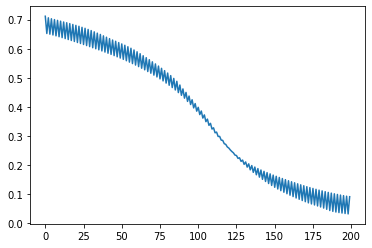

In [63]:
from matplotlib import pyplot as plt
plt.plot(loss_vec)

In [ ]:
for param_name, param in model.bert.embeddings.named_parameters():
    print(param_name, param.requires_grad)

word_embeddings.weight False
position_embeddings.weight False
token_type_embeddings.weight False
LayerNorm.weight False
LayerNorm.bias False


## With 🤗 Trainer

In [13]:
def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {'accuracy': (preds == label_ids).astype(np.float32).mean().item()}

In [68]:
epochs = 20
batchsize = 6
lr = 5e-4
n_tokens = 20
scheduler_type = "linear"
wd = 0.005
warmup_ratio = 0.1

config = {
    'n_tokens': n_tokens,
    'n_class':19,
    'numchoices':2,
    'train_bert': False
}

from transformers import TrainingArguments, Trainer
args = TrainingArguments(
    model_name, 
    learning_rate=lr,
    per_device_train_batch_size=batchsize,
    per_device_eval_batch_size=batchsize,
    num_train_epochs=epochs,
    gradient_accumulation_steps=1, 
    weight_decay=wd,
    warmup_ratio = warmup_ratio,
    lr_scheduler_type=scheduler_type,
    logging_strategy="epoch",
    evaluation_strategy = "epoch",
    save_strategy = "no",
    report_to="tensorboard",
    load_best_model_at_end = False,
    seed = myseed
)

PyTorch: setting up devices


In [69]:

model = BertPromptForMultipleChoice.from_pretrained('bert-base-chinese', config).to("cuda")
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(),
    compute_metrics=compute_metrics,
)

loading configuration file https://huggingface.co/bert-base-chinese/resolve/main/config.json from cache at /home/seantyh/.cache/huggingface/transformers/6cc404ca8136bc87bae0fb24f2259904943d776a6c5ddc26598bbdc319476f42.0f9bcd8314d841c06633e7b92b04509f1802c16796ee67b0f1177065739e24ae
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vo

** total param is 292609
** train bert? False


In [70]:
# bert freeze version 
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertPromptForMultipleChoice.forward` and have been ignored: pos, zh_dot_gloss, src, word, __index_level_0__, type_class, zh_dot_type, is_one_ans, zh_dot_type_2, eng word, is_2choice, zh_type_class, instance, dot_type_1, dot_type_2.
***** Running training *****
  Num examples = 455
  Num Epochs = 20
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 1
  Total optimization steps = 1520


Epoch,Training Loss,Validation Loss,Accuracy
1,0.705700,0.688624,0.464912
2,0.686400,0.694512,0.508772
3,0.659800,0.691805,0.596491
4,0.642300,0.766242,0.596491
5,0.626800,0.704495,0.622807
6,0.565800,0.665871,0.631579
7,0.583100,0.613542,0.657895
8,0.542600,0.717002,0.640351
9,0.451000,0.834621,0.631579
10,0.433400,0.791211,0.666667


The following columns in the evaluation set  don't have a corresponding argument in `BertPromptForMultipleChoice.forward` and have been ignored: pos, zh_dot_gloss, src, word, __index_level_0__, type_class, zh_dot_type, is_one_ans, zh_dot_type_2, eng word, is_2choice, zh_type_class, instance, dot_type_1, dot_type_2.
***** Running Evaluation *****
  Num examples = 114
  Batch size = 6
The following columns in the evaluation set  don't have a corresponding argument in `BertPromptForMultipleChoice.forward` and have been ignored: pos, zh_dot_gloss, src, word, __index_level_0__, type_class, zh_dot_type, is_one_ans, zh_dot_type_2, eng word, is_2choice, zh_type_class, instance, dot_type_1, dot_type_2.
***** Running Evaluation *****
  Num examples = 114
  Batch size = 6
The following columns in the evaluation set  don't have a corresponding argument in `BertPromptForMultipleChoice.forward` and have been ignored: pos, zh_dot_gloss, src, word, __index_level_0__, type_class, zh_dot_type, is_one_an

TrainOutput(global_step=1520, training_loss=0.43546164224022316, metrics={'train_runtime': 43.8526, 'train_samples_per_second': 207.513, 'train_steps_per_second': 34.662, 'total_flos': 615881950804344.0, 'train_loss': 0.43546164224022316, 'epoch': 20.0})